<a href="https://colab.research.google.com/github/youzhanghe123/traditional-NLP-sentiment-classification/blob/main/ngram_tf_idf_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Explore the datasets (display the first few rows, check balance, etc.)

# ---------------------- Data Preprocessing ----------------------

# Define a function for text cleaning
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Apply text cleaning
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
val_data['cleaned_text'] = val_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

n-gram and tf-idf

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [10]:
def prediction(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    conf = confusion_matrix(y_valid, pred)
    return model, acc, f1, conf

In [9]:
transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3),
                              lowercase=True, max_features=100000)
X = transformer.fit_transform(train_data['cleaned_text'])
y = train_data["label"]

In [17]:
X_test=transformer.transform(test_data['cleaned_text'])

In [18]:
y_test = test_data["label"]

In [19]:
lgmodel = LogisticRegression(C=1, random_state=42, n_jobs=-1)
lgmodel.fit(X,y)

LogisticRegression(C=1, n_jobs=-1, random_state=42)

In [22]:
pred = lgmodel.predict(X)
acc = accuracy_score(y, pred)
f1 = f1_score(y,pred)
conf = confusion_matrix(y, pred)

In [23]:
print("accuracy for training set ", acc, " f1 score for training set ", f1)

accuracy for training set  0.9481  f1 score for training set  0.9485374318294496


In [24]:
print(conf)

[[9396  604]
 [ 434 9566]]


In [28]:
test_pred = lgmodel.predict(X_test)
acc_test = accuracy_score(y_test, test_pred)
f1_test = f1_score(y_test,test_pred)
conf = confusion_matrix(y_test, test_pred)

In [29]:
print("accuracy for test set ", acc_test, " f1 score for test set ", f1_test)

accuracy for test set  0.87768  f1 score for test set  0.878351499721537


word embedding + lstm

In [ ]:
# ---------------------- Model Building ----------------------

# Define your RNN model architecture
embedding_dim = 64
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['cleaned_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_text'])

max_length = 300    # Adjust based on your text data
padding_type = 'post' # Choose 'post' or 'pre'
trunc_type = 'post'   # Choose 'post' or 'pre'
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),  # Can adjust the number of units
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(30, activation="relu"),
    Dense(15, activation="relu"),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 300, 128)          98816     
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 15)                4

In [ ]:
# ---------------------- Model Training ----------------------
# Train the model
num_epochs = 10  # Adjust as needed
batch_size = 64  # Adjust as needed

history = model.fit(
    train_padded, train_data['label'],
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(val_padded, val_data['label']),
    verbose=1
)


Epoch 1/10
313/313 [==============================] - 220s 691ms/step - loss: 0.6925 - accuracy: 0.5119 - val_loss: 0.6903 - val_accuracy: 0.5290
Epoch 2/10
313/313 [==============================] - 215s 686ms/step - loss: 0.6746 - accuracy: 0.5448 - val_loss: 0.6864 - val_accuracy: 0.4988
Epoch 3/10
313/313 [==============================] - 214s 684ms/step - loss: 0.6748 - accuracy: 0.5503 - val_loss: 0.6781 - val_accuracy: 0.5848
Epoch 4/10
313/313 [==============================] - 213s 679ms/step - loss: 0.6622 - accuracy: 0.5774 - val_loss: 0.6732 - val_accuracy: 0.5542
Epoch 5/10
313/313 [==============================] - 214s 683ms/step - loss: 0.5702 - accuracy: 0.6951 - val_loss: 0.4639 - val_accuracy: 0.8046
Epoch 6/10
313/313 [==============================] - 220s 702ms/step - loss: 0.4120 - accuracy: 0.8318 - val_loss: 0.4829 - val_accuracy: 0.7856
Epoch 7/10
313/313 [==============================] - 216s 690ms/step - loss: 0.3584 - accuracy: 0.8633 - val_loss: 0.4072 -

782/782 [==============================] - 95s 122ms/step - loss: 0.3848 - accuracy: 0.8374
Test Loss: 0.3848341107368469, Test Accuracy: 0.8374000191688538
782/782 [==============================] - 97s 123ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10689  1811]
 [ 2254 10246]]


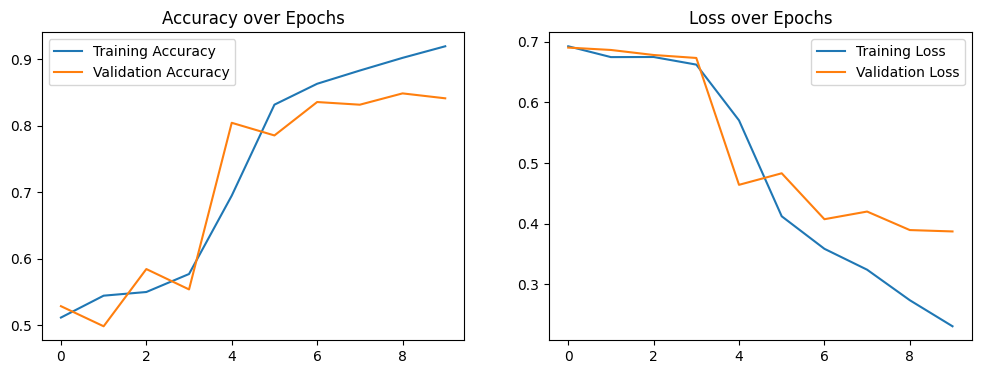

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_padded, test_data['label'])
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Generate predictions
predictions = model.predict(test_padded)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# Classification report and confusion matrix
print(classification_report(test_data['label'], predicted_labels))
print(confusion_matrix(test_data['label'], predicted_labels))

# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

In [ ]:
# Classification report and confusion matrix
print(classification_report(test_data['label'], predicted_labels))
print(confusion_matrix(test_data['label'], predicted_labels))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

[[10689  1811]
 [ 2254 10246]]


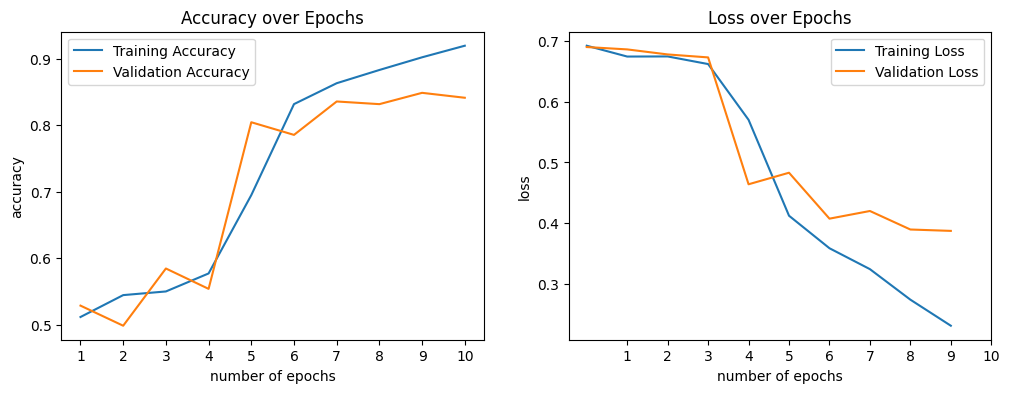

In [ ]:
# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([i+1 for i in range(num_epochs)], history.history['accuracy'], label='Training Accuracy')
plt.plot([i+1 for i in range(num_epochs)], history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.xticks([i+1 for i in range(num_epochs)])
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.xticks([i+1 for i in range(num_epochs)])
plt.title('Loss over Epochs')
plt.show()